In [51]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.measure import regionprops, label
import re
import pandas as pd
import gc
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as D
from torch import from_numpy

In [155]:
'''
Partitions the folder downloaded into smaller ones, which is easier to handle.
EX: ~/.../subset0/img.mhd -> ~/.../subset0/0/img.mhd
n_files: max number of files in a folder (the /0/ maximum)
'''

def split_dir(d, n_files = 8):
    lst_files = []
    file_c = 0
    c = 0
    new_dir = d
    for file in os.listdir(d):
        if re.search('.mhd$', file) or re.search('.raw$', file):
            lst_files.append(file)
    for file in sorted(lst_files):
        if c == 2 * n_files or file_c == 0: # EVEN to group the .raw and .mhd files in same directory
            new_dir = d + str(file_c) + '/'
            os.makedirs(new_dir, 0o755, exist_ok = True)
            c = 0
            file_c += 1
        os.rename(d + file, new_dir + file)
        c += 1

In [156]:
'''
Initial processing functions.
'''

# load in SimpleITK .mhd file as numpy array
def load_img(filename):
    itkimage = sitk.ReadImage(filename)
    numpy_image = sitk.GetArrayFromImage(itkimage) # z, y, x...
    numpy_origin = np.array(itkimage.GetOrigin()) # x, y, z...
    numpy_spacing = np.array(itkimage.GetSpacing())
    return numpy_image, numpy_origin, numpy_spacing

# normalize image
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean)/std

# show distribution of intensity
def distribution(normalize_img):
    plt.hist(normalize_img.flatten(), bins = 200)
    plt.show()

In [157]:
# img, orig, spacing = load_img('/Volumes/KaneData/subset1/0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd')
# norm_img = normalize(img)
# minimum = np.min(norm_img)
# print(norm_img[norm_img == minimum].shape[0]/norm_img[(norm_img - minimum < 0.75)].shape[0])
# distribution(norm_img)

In [171]:
'''
Convert norm_img to an image (numpy array) with only 1s and 0s.
1s = initial lungs regions + noise
0s = background/non-lung tissue + noise
PRECONDITION: norm_img is a normalized numpy array
'''

def convert_binary(norm_img):
    # move outliers of images with the extra background circle to 
    # intensity that won't affect kmeans significantly
    minimum = np.min(norm_img)
    
    # empirically determined
    if norm_img[norm_img == minimum].shape[0]/norm_img[(norm_img - minimum < 0.75)].shape[0] < 0.1:
        norm_img[norm_img == minimum] = np.median(norm_img)
        print('Detected two peaks.')
    else:
        norm_img[(norm_img - minimum < 0.75)] = np.median(norm_img) 
        print('Detected three peaks.')
    
    print('Kmeans is doing its thing.')
    # empirical values but haven't really tested thoroughly, kmeans takes too long
    kmeans = KMeans(n_clusters = 2, random_state = 0, n_init = 1, max_iter = 1).fit(norm_img.flatten().reshape(-1, 1))
    print('Kmeans is done.')
    gc.collect()
    
    # convert image to 1s and 0s based on threshold
    centers = np.sort(kmeans.cluster_centers_.flatten())
    thresh = (centers[0] + centers[1]) / 2
    bin_img = np.where(norm_img < thresh, 1.0, 0.0)
    return bin_img  

In [172]:
# bin_img = convert_binary(normalize(img))
# plt.imshow(bin_img[int(0.5*bin_img.shape[0]), :, :])
# plt.show()

In [173]:
'''
Removes noise regions from bin_img through erosion and then dilation. 
PRECONDITION: bin_img is binary numpy array
'''

def make_regions(bin_img):
    for s in range(bin_img.shape[0]):
        s1 = bin_img[s,:,:]
        s2 = binary_erosion(s1, selem = np.ones([2, 2]))  # empirically determined
        bin_img[s,:,:] = binary_dilation(s2, selem = np.ones([8, 8])) # empirically determined
    return bin_img

In [174]:
# x_img = make_regions(bin_img)
# plt.imshow(x_img[int(0.5*x_img.shape[0]), :, :])
# plt.show()

In [183]:
'''
Isolates the lung regions and makes a binary mask over them.
1s = lung regions
0s = non-lung regions
PRECONDITION: reg_img is a non-noisy binary image
'''

def make_mask(reg_img):
    mask = np.zeros(reg_img.shape)
    for s in range(reg_img.shape[0]):
        # a slice in the 3D reg_img
        s1 = reg_img[s,:,:]
        props = regionprops(label(s1))
        labels = []
        for p in props:
            B = p.bbox
            # empirically determined, region has to be within confines and large enough
            if (B[0] > 10 and B[2] < 505 and B[1] > 10 and 
                B[3] < 505 and B[2] - B[0] > 35 and B[3] - B[1] > 35):
                labels.append(p.label)
        for l in labels:
            mask[s, :, :] = mask[s, :, :] + np.where(label(s1) == l, 1, 0)
        mask[s, :, :] = binary_dilation(mask[s, :, :], selem = np.ones([8, 8])) # empirically determined
    return mask

In [184]:
'''
Applies the mask to the original, non-normalized image. 
Renormalizes using significant regions only, which is desired.
PRECONDITION: mask is original's corresponding mask
'''

def mask_on_orig(original, mask):
    new_img = original * mask
    
    mean = np.mean(original[mask > 0])
    std = np.std(original[mask > 0])
    new_img = (new_img - mean)/std
    # set non-lung regions to -5, which is logical since it's highly unlikely to interfere
    new_img[mask==0] = -5 
    return new_img

In [185]:
'''
Uses previous methods to process through a whole image.
Returns the masked image and (origin and spacing) from SimpleITK
'''

def process_img(filename):
    img, origin, spacing = load_img(filename)
    norm_img = normalize(img)
    bin_img = convert_binary(norm_img)
    reg_img = make_regions(bin_img)
    mask = make_mask(reg_img)
    masked_img = mask_on_orig(img, mask)
    
    # visualize a slice to make sure mask is generated correctly
    plt.subplot(231)
    plt.imshow(img[int(0.3 * img.shape[0]), 0:512, 0:512])
    plt.subplot(232)
    plt.imshow(img[int(0.5 * img.shape[0]), 0:512, 0:512])
    plt.subplot(233)
    plt.imshow(img[int(0.8 * img.shape[0]), 0:512, 0:512])
    plt.subplot(234)
    plt.imshow(masked_img[int(0.3 * masked_img.shape[0]), 0:512, 0:512])
    plt.subplot(235)
    plt.imshow(masked_img[int(0.5 * masked_img.shape[0]), 0:512, 0:512])
    plt.subplot(236)
    plt.imshow(masked_img[int(0.8 * masked_img.shape[0]), 0:512, 0:512])
    plt.show()
    
    return masked_img, origin, spacing

In [186]:
# process_img('/Volumes/KaneData/subset1/0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd')

In [187]:
'''
Processes all LUNA files in a directory:
    - creates a new directory on the same level as the directory of images
    - uses process_img to get the masked image, origin, spacing for each image
    - stores the masked image array into a text file in the new directory
    - stores the origin, spacing coordinates, size of array into a csv file in out_meta
'''

def process_dir(d, out_dir, out_meta):
    os.makedirs(out_dir, 0o755, exist_ok = True)
    
    originsZ = []
    originsY = []
    originsX = []
    spacingsZ = []
    spacingsY = []
    spacingsX = []
    names = []
    zDim = []
    yDim = []
    xDim = []
    df = pd.read_csv(out_meta)
    
    for file in os.listdir(d):
        gc.collect()
        if re.search('.mhd$', file):
            print(file + ' is processing')
            img, origin, spacing = process_img(d + file)
            np.save(out_dir + 'p_' + re.split('.mhd$', file)[0], img)
            gc.collect()
            
            z = img.shape[0]
            y = img.shape[1]
            x = img.shape[2]
            
            originsZ.append(origin[2])
            originsY.append(origin[1])
            originsX.append(origin[0])
            spacingsZ.append(spacing[2])
            spacingsY.append(spacing[1])
            spacingsX.append(spacing[0])
            zDim.append(z)
            yDim.append(y)
            xDim.append(x)
            names.append(re.split('.mhd$', file)[0])
                        
    new = pd.DataFrame({'Name': names, 'OriginZ': originsZ, 'OriginY': originsY, 'OriginX': originsX,
                        'SpacingZ': spacingsZ, 'SpacingY': spacingsY, 'SpacingX': spacingsX, 
                        'zDim': zDim, 'yDim': yDim, 'xDim': xDim})
    df = pd.concat([df, new], axis = 0)
    df.to_csv(out_meta, index = False)

1.3.6.1.4.1.14519.5.2.1.6279.6001.100684836163890911914061745866.mhd is processing
Detected two peaks.
Kmeans is doing its thing.
Kmeans is done.


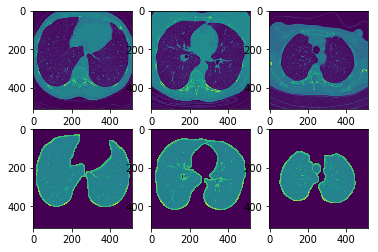

1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


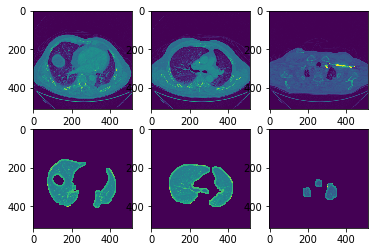

1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


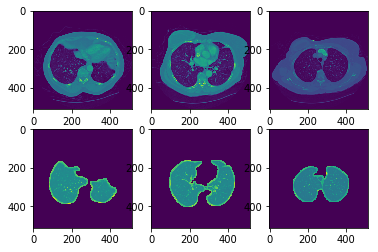

1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


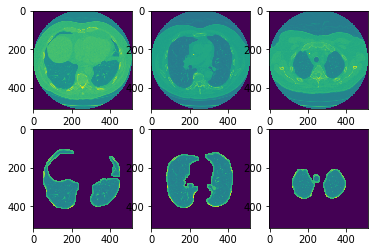

1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


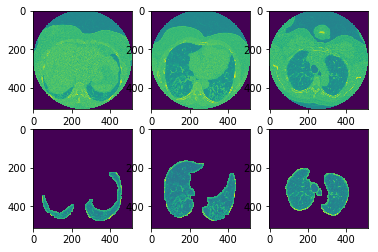

1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


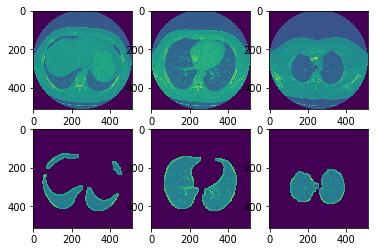

1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


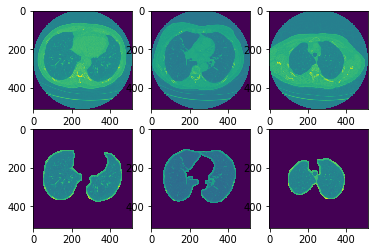

1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637.mhd is processing
Detected two peaks.
Kmeans is doing its thing.
Kmeans is done.


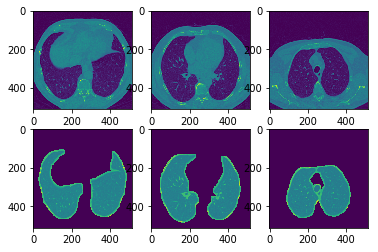

7

In [180]:
process_dir('/Volumes/KaneData/subset1/0/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


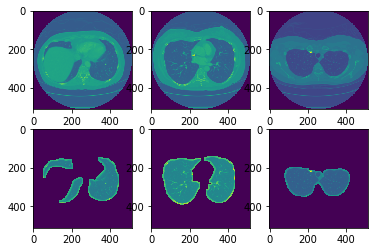

1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


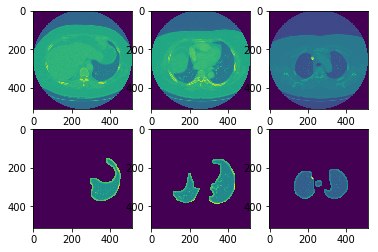

1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd is processing
Detected two peaks.
Kmeans is doing its thing.
Kmeans is done.


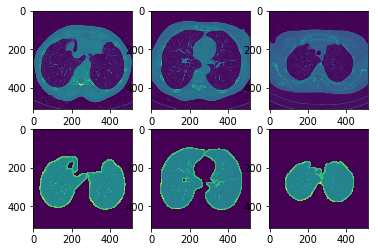

1.3.6.1.4.1.14519.5.2.1.6279.6001.139595277234735528205899724196.mhd is processing
Detected two peaks.
Kmeans is doing its thing.
Kmeans is done.


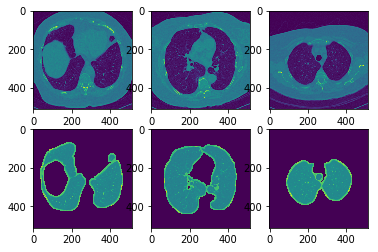

1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


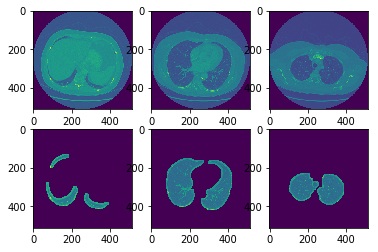

1.3.6.1.4.1.14519.5.2.1.6279.6001.144943344795414353192059796098.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


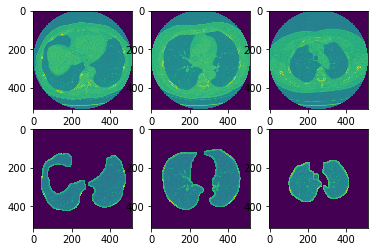

1.3.6.1.4.1.14519.5.2.1.6279.6001.145759169833745025756371695397.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


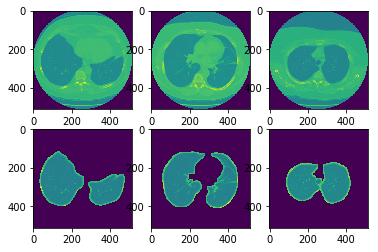

1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


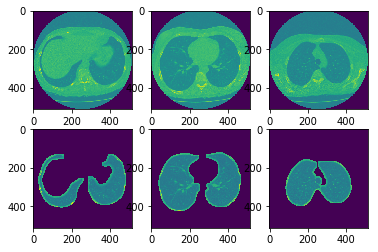

7

In [181]:
process_dir('/Volumes/KaneData/subset1/1/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


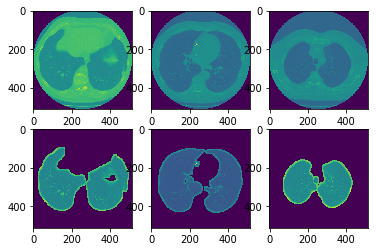

1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


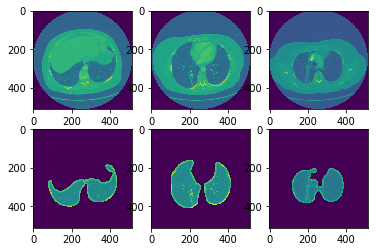

1.3.6.1.4.1.14519.5.2.1.6279.6001.161073793312426102774780216551.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


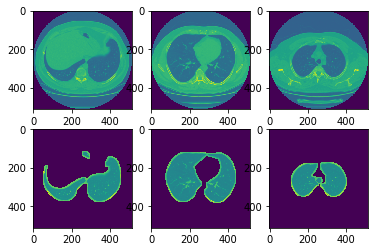

1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


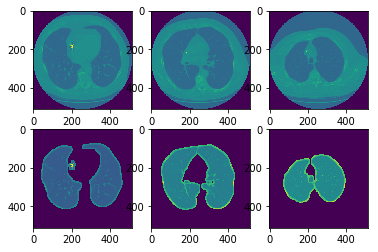

1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


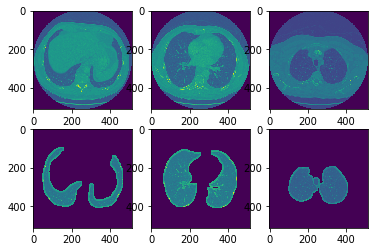

1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd is processing
Detected two peaks.
Kmeans is doing its thing.
Kmeans is done.


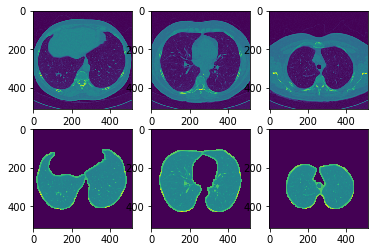

1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579.mhd is processing
Detected three peaks.
Kmeans is doing its thing.
Kmeans is done.


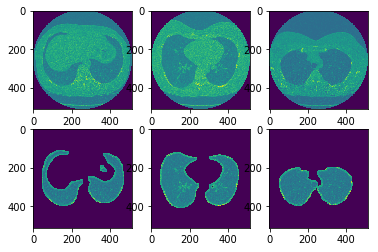

1.3.6.1.4.1.14519.5.2.1.6279.6001.168037818448885856452592057286.mhd is processing
Detected two peaks.
Kmeans is doing its thing.


KeyboardInterrupt: 

In [182]:
process_dir('/Volumes/KaneData/subset1/2/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/3/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/4/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/5/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/6/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/7/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/8/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/9/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/10/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [ ]:
process_dir('/Volumes/KaneData/subset1/11/', 
            '/Volumes/KaneData/processed1/', 
            '/Volumes/KaneData/meta_1.csv')
gc.collect()

In [60]:
'''
Custom dataset for the processed lung images:
    - Takes in the corresponding meta csv file, nodule csv file, and processed img directory
    - When getting an item (image), creates the label and returns 
      a dict with the image as a tensor and label as a tensor
'''
class LungsDataset(D.Dataset):
    def __init__(self, meta_file, nodule_file, img_dir):
        self.meta = pd.read_csv(meta_file)
        self.cands = pd.read_csv(nodule_file)
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[0]
        
        # meta information for the scan
        name = row['Name']
        originX = row['OriginX']
        originY = row['OriginY']
        originZ = row['OriginZ']
        spacingX = row['SpacingX']
        spacingY = row['SpacingY']
        spacingZ = row['SpacingZ']

        # nodules for each scan
        nodules = self.cands[self.cands['seriesuid'] == name][['coordX', 'coordY', 'coordZ']]
        nodules['coordX'] = ((nodules['coordX'] - originX)/spacingX).astype(int)
        nodules['coordY'] = ((nodules['coordY'] - originY)/spacingY).astype(int)
        nodules['coordZ'] = ((nodules['coordZ'] - originZ)/spacingZ).astype(int)
        
        # processed image (numpy array)
        for file in os.listdir(self.img_dir):
            if re.search(name + '.npy$', file):
                img = np.load(self.img_dir + 'p_' + name + '.npy')
                break
                
        # convert nodules to 1-hot
        label = np.zeros(img.shape)
        nodules = nodules.values
        for ind in range(nodules.shape[0]):
            nod = nodules[ind, :]
            label[nod[2], nod[1], nod[0]] = 1
        
        # convert img, label into tensors
        return {'img': from_numpy(img), 'label': from_numpy(label)}

In [41]:
ds_0 = LungsDataset('/Volumes/KaneData/processed0/meta_0.csv', 
                    '/Volumes/KaneData/candidates_V2.csv', 
                    '/Volumes/KaneData/processed0/')
dl_0 = D.DataLoader(ds_0, shuffle = True)

In [42]:
'''
Begin training/evaluation of model.

Questions: 
    - 1) How do I resize images to have same depths to normalize? 
        Final layer can just be resize to original size, and one-hot.
    - 2) How do I deal with multiple outputs? 
        Same.
    - 3) How should I format final layer to reflect nature of outputs?
        Same.
    - 4) Am I using 3d layers incorrectly? Switch to 2d? 
'''

class UNetDBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(UNetDBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size = 3, padding = 1)
        self.batch = nn.BatchNorm3d(out_c)
        self.pool = nn.MaxPool3d(2)
    def forward(self, x): 
        x = F.leaky_relu(conv1(x))
        x = batch(x)
        x = F.leaky_relu(conv2(x))
        x = batch(x)
        x = pool(x)
        return x

class UNetUBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(UNetUBlock, self).__init__()
        self.convt1 = nn.ConvTranspose3d(in_c, in_c, 2, stride = 2)
        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size = 3, padding = 1)
        self.batch = nn.BatchNorm3d(out_c)
        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size = 3, padding = 1)
    def forward(self, x): 
        x = F.leaky_relu(conv1(x))
        x = batch(x)
        x = F.leaky_relu(conv2(x))
        x = batch(x)
        return x
    
class UNetBBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(UNetBBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size = 3, padding = 1)
        self.batch = nn.BatchNorm3d(out_c)
        self.dropout = nn.Dropout3d()
    def forward(self, x):
        x = conv1(x)
        x = batch(x)
        x = dropout(x)
        x = conv2(x)
        x = batch(x)
        x = dropout(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        initf = 32
        self.d1 = UNetDBlock(1, initf)
        self.d2 = UNetDBlock(initf, initf * 2)
        self.d3 = UNetDBlock(initf * 2, initf * 4)
        self.d4 = UNetDBlock(initf * 4, initf * 8)
        self.b = UNetBBlock(initf * 8, initf * 16)
        self.u1 = UNetUBlock(initf * 16, initf * 8)
        self.u2 = UNetUBlock(initf * 8, initf * 4)
        self.u3 = UNetUBlock(initf * 4, initf * 2)
        self.u4 = UNetUBlock(initf * 2, initf)
        self.final = nn.Conv3d(initf, 1, kernel_size = 1)
        self.final_sig = nn.Sigmoid()
    def forward(self, x): # D * H * W
        x = d1.forward(x) # D * 512 * 512 -> D/2 * 256 * 256
        x = d2.forward(x) # D/2 * 256 * 256 -> D/4 * 128 * 128
        x = d3.forward(x) # D/4 * 128 * 128 -> D/8 * 64 * 64
        x = d4.forward(x) # D/8 * 64 * 64 -> D/16 * 32 * 32
        
        x = b.forward(x) # D/16 * 32 * 32 -> D/16 * 32 * 32
        
        x = u1.forward(x) # D/16 * 32 * 32 -> D/8 * 64 * 64
        x = u2.forward(x) # D/8 * 64 * 64 -> D/4 * 128 * 128
        x = u3.forward(x) # D/4 * 128 * 128 -> D/2 * 256 * 256
        x = u4.forward(x) # D/2 * 256 * 256 -> D * 512 * 512
        
        x = final(x) # D * 512 * 512 -> D * 512 * 512 (1 channel)
        x = final_sig(x) # D * 512 * 512 -> D * 512 * 512
        return x

In [43]:
'''
Build optimizer, loss function family.
'''

model = UNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [50]:
'''
Train the model.
'''

def train(model, criterion, optimizer, data_loader):
    for epoch in range(2):
        running_loss = 0.0
        
        # currently, this code only works for batch size = 1, can change with inner for loop
        for i_batch, batch in enumerate(data_loader): 
            tr_img = batch['img']
            tr_label = batch['label']

            optimizer.zero_grad()

            output = model.forward(tr_img)
            loss = criterion(output, tr_label)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print("loss for epoch of the processed batch: " + str(running_loss / len(train_data)))